In [176]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore') 
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='whitegrid', rc=rc)

# 北京大学通选课选课指导
数据来源：本篇数据来源网址——北大教务部(http://www.dean.pku.edu.cn/)，爬取公开数据——2020-2021学年度本科开放课程信息

受众：北京大学有通选课选课需要的本科生

目标：从本科生在选课时比较关注的角度切入，为选课提供指导意见\
比如，课程类别、课程评分、考核方式、课程形似度等

### 数据处理与整合
##### 读取原始格式为JSON的数据为DataFrame格式

In [177]:
firstSEM = [('result_firstSEM/'+i) for i in os.listdir( 'result_firstSEM')]
secondSEM = [('result_secondSEM/'+i) for i in os.listdir( 'result_secondSEM')]

data = pd.DataFrame(columns= ['course_id','credit','hours','course_name',
                              'department','course_type','course_domain','prerequisites',
                              'language','score','introduction','syllabus'])
for i in (firstSEM + secondSEM):
    with open(i, encoding='utf-8') as j:
        # 读取文件
        result = json.load(j)
        # 循环遍历
        for i in result:
            data.loc[len(data)] = [i.get('课程号'),i.get('学分'),i.get('课时'),i.get('课程名称'),
                                i.get('开课院系'),i.get('课程类型'), i.get('通选课领域'),i.get('先修课程'),
                                i.get('授课语言'),i.get('教学评估'),i.get('中文简介'),i.get('教学大纲')]

##### 根据后续需求处理数据，加工特征字段
不去重，因为重复是由相同内容的课程开设了多个平行教学班导致而非数据采集错误

In [178]:
#可视化主要关注通选课类型的课程
data = data[data['course_type'] == '通选课']
#提取教师姓名字段
data['teacher'] = data['score'].apply(lambda x : x.split('：')[0] if x.split('：') != x else np.nan)
#提取课程上一学期评分字段
def score_produce(x):
    try:
        score = x.split('：')[-1][:-1]
    except:
        return np.nan
    if score == '80及以下':
        return 80
    elif score =='80-85':
        return 85
    elif score == '85-90':
        return 90
    elif score == '90-95':
        return 95
    elif score == '95-100':
        return 100
    else:
        return np.nan
data['score'] = data['score'].apply(score_produce)
#将能转化为浮点数的学分转化，其余替换为缺失
def hours_transform(x):
    try:
        return float(x)
    except:
        return np.nan
data['hours'] = data['hours'].apply(hours_transform)
#将能转化为整数的学分转化，其余替换为缺失
def credit_transform(x):
    try:
        return int(x)
    except:
        return np.nan
data['credit'] = data['credit'].apply(credit_transform)
#计算学分/学时（衡量‘效率’）
data['ratio'] = data['credit']/data['hours']
#去掉中文开课院系名称后面的‘（英文开课院系名称)’
data['department'] = data['department'].apply(lambda x:x.split('(')[0])

#从教学大纲与中文简介字段，通过手工构建的主题词表，提取出考核方式dummy字段
def extract(x, vocab_list):
    for i in vocab_list:
        if i in x:
            return '1'
    return '0'

data['extract_from'] = data['introduction'] + data['syllabus']
data['performance'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['课堂表现','上课表现','平时表现','随堂表现','课堂发言','回答问题','课堂参与','课上参与','平时成绩']))
data['quiz'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['小测','随堂测验','小测验','平时测验','课堂多次测验','课堂测验']))
data['pre'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['课堂报告','展示','汇报','口头报告','讲演','演讲','演示']))
data['paper'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['专题论文','学期论文','课程论文','期中论文','期中小论文','小论文','期末总结作文','期末论文','阅读报告','读书报告','文献阅读报告','实践报告','文献报告','学习报告','期中报告','中期报告','期末报告','调研报告','书面报告','学期报告','期终报告','研究报告','课程报告','总结报告']))
data['project'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['大作业','自主项目','项目','课程项目','大课题']))
data['midterm_exam'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['期中考试','期中随堂测验','期中笔试','期中小测','期中考','期中课堂考试','期中考核','期中笔试','期中开卷','期中闭卷']))
data['final_exam'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['期末考试','期终考试','期末笔试','期末考核','结业考试','结课考试','期末考','期末课堂考试','期末随堂考试','期末开卷','期末闭卷']))
data['open_book'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['开卷']))
data['closed_book'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['闭卷']))
data['group_work'] = data['extract_from'] .apply(lambda x: extract(x, 
                                                                    ['小组','团队','组队','合作']))
#先修课要求‘无’处理
data['prerequisites'] = data['prerequisites'].apply(lambda x : x if '无' not in x else np.nan)
#将json中空白字符串替换为缺失值
data = data.applymap(lambda x : x if x != " " else np.nan)
#data.to_csv("data.csv")

##### 缺失值统计

In [179]:
data.isna().sum().reset_index()[data.isna().sum().reset_index()[0]!=0]
#没有先修课使用np.nan填充；其余字段缺失值极少，应用到时会进行过滤

,index,0
7,prerequisites,167
9,score,16
10,introduction,2
14,extract_from,1


### 开课概况

通识教育是大学教育中不可或缺的一部分，本科生通过通识课的学习可以有更多元的价值观更好适应社会发展。\
北京大学设有6大门类通识领域，分别是：\
A、数学与自然科学\
B、社会科学\
C、哲学与心理学\
D、历史学\
E、语言学、文学、艺术与美育\
F、社会可持续发展

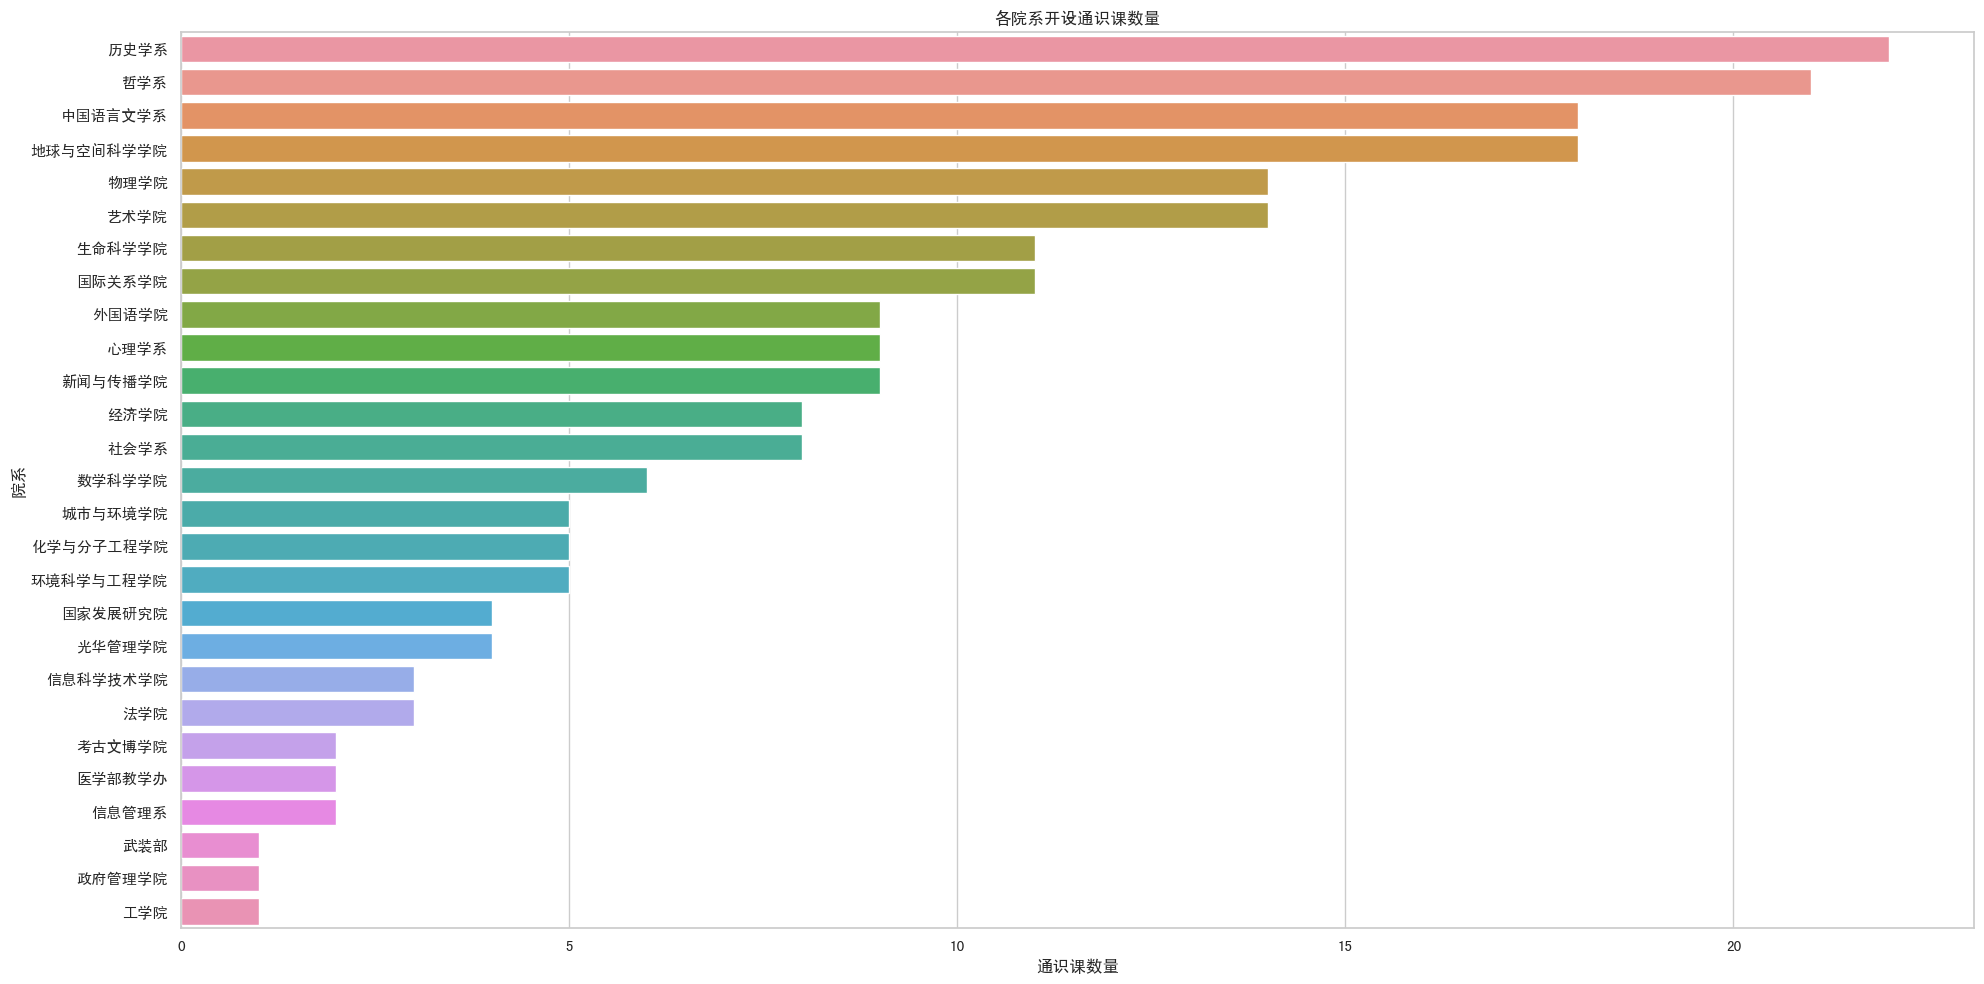

In [181]:
statistics = data.groupby("department").count()['course_id'].reset_index()
statistics.columns=["院系","通识课数量"]
statistics = statistics.sort_values("通识课数量",ascending=False)
plt.figure(figsize = [20,10],dpi=100)
plt.title('各院系开设通识课数量')
ax=sns.barplot(data=statistics, x="通识课数量", y='院系' )
plt.tight_layout()#各院系通识课数量.png

2020-2021学年度学校共开设216门通选课，共27个院系开设通选课。\
其中历史学系和哲学系提供20+门，中文系、地空学院也都开设了15余门通选课供同学们选择，扩大知识面。\
开课数量低于5门的院系有10个，这可能与这些院系相关课程专业门槛较高、不适合作为通选课开设或院系人力物力资源不足有关。

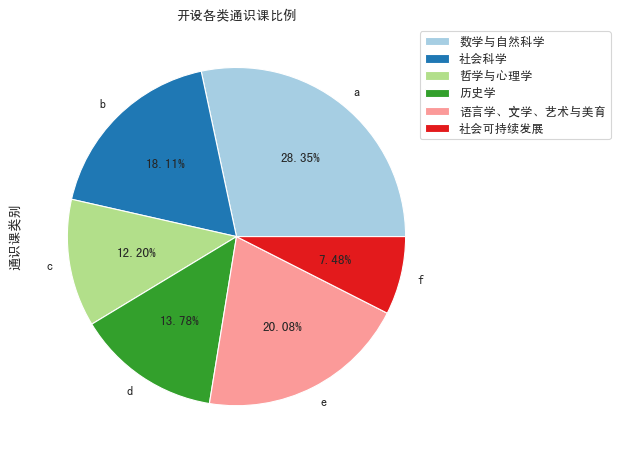

In [182]:
total_domain=[]
for x in data['course_domain'].tolist():
    total_domain+=x.split(",")
plt.figure(figsize=[100,7],dpi=80)
pd.Series(total_domain).value_counts().sort_index().plot.pie(autopct='%.2f%%',colors=sns.color_palette("Paired",12))
plt.ylabel('通识课类别')
plt.title('开设各类通识课比例')
plt.legend(['数学与自然科学','社会科学','哲学与心理学','历史学','语言学、文学、艺术与美育','社会可持续发展'],loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

各类通识课开设数量整体分布较为均衡，A、F类略显偏态。\
由于A类课程是六大门类中唯一偏重理科背景的，所以从文理均衡的角度来说A类课数量接近30%也是合理的。\
对社科、哲学心理学、历史学、语言文学、艺术感兴趣的同学都有丰富的选择。\
后期学校可以考虑增开更多F类课程，助力本科生可持续发展观的普及。

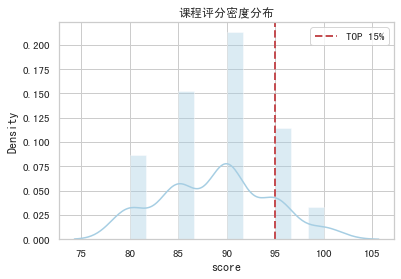

In [183]:
sns.set_palette("Paired") 
sns.distplot(data[data['score'].isna()==False]['score'])
plt.axvline(x=95, c="r", ls="--", lw=2, label='TOP 15%')
plt.legend()
plt.title('课程评分密度分布')
plt.show()

上图可以看出学生对于通选课程的打分符合正态分布，90分一档的课程最多，位于90分以上即95和100两档的课程只占15%。\
如果可以抢到，建议gpa压力较大的同学优先选择得分在最高两档的通选课。

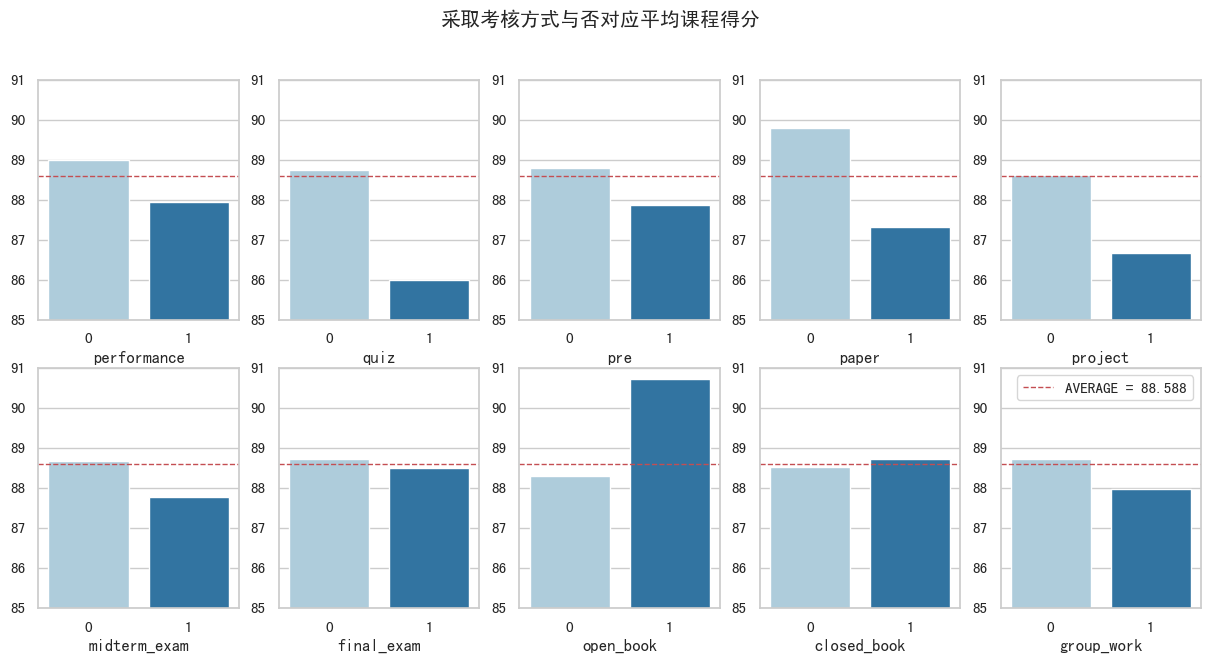

In [184]:
data['sum'] = data[['performance', 'quiz', 'pre', 'paper', 'project', 'midterm_exam',
       'final_exam', 'open_book', 'closed_book', 'group_work']].applymap(int).apply(sum,axis=1)
#过滤掉文字说明未提及考核方式的课程
filter_data = data[data['sum']!=0]

axis = ['performance', 'quiz', 'pre', 'paper', 'project', 'midterm_exam',
       'final_exam', 'open_book', 'closed_book', 'group_work']

plt.figure(figsize = [15,7],dpi=100)

for i in range(len(axis)):
    plt.subplot(2,5,i+1)
    sns.barplot(data = filter_data.groupby(axis[i]).mean()['score'].reset_index().sort_values(axis[i],ascending=True), x=axis[i], y='score' )
    plt.ylim(85,91)
    plt.axhline(y=filter_data.score.mean(), c="r", ls="--", lw=1,label=f'AVERAGE = {round(filter_data.score.mean(),3)}')
    plt.ylabel('')
plt.suptitle('采取考核方式与否对应平均课程得分')
plt.legend()
plt.show()

从上图可以看出，在各种考核方式中，开卷考试对应课程平均得分高于其他课程；论文课程平均得分显著低于不以论文作为考核方式的课程；课堂表现、小测、pre、大作业、期中考试、小组作业等考核方式会给课程带来一定程度负面评价，希望同学们选课时合理考虑自己的特长，避开雷区。

In [185]:
from pyecharts import options as opts
from pyecharts.charts import Graph
from pypinyin import pinyin, Style
original=pd.read_csv("数据集.csv")
#相同课程只保留一次
original= original.drop_duplicates('course_name').sort_values("department")
#将开课院系作为通选课划分标签
department_list = original["department"].unique().tolist()
department_list.sort(key=lambda keys:[pinyin(i, style=Style.TONE3) for i in keys])
categories=[]
for i in department_list:
    categories.append({"name": i})
category_dict={}
for i in range(len(department_list)):
    category_dict[department_list[i]]=i
original["id"]=range(len(original))
def cate_tran(x):
    return category_dict[x]
original["category"]=original["department"].apply(cate_tran)
original["name"]=original['course_name']
original["id"]=original["id"].apply(str)
nodes=original[['id','name','category']].to_dict(orient='records')

In [186]:
import sys
from sentence_transformers.util import cos_sim  
from sentence_transformers import SentenceTransformer as SBert
model = SBert('paraphrase-multilingual-MiniLM-L12-v2')
# 联合教学大纲与中文简介字段计算课程间相似度
sentences1 = original['extract_from'].tolist()
sentences2 = original['extract_from'].tolist()
#生成语句embedding
embeddings1 = model.encode(sentences1)
embeddings2 = model.encode(sentences2)
#计算余弦相似度
cosine_scores = cos_sim(embeddings1, embeddings2)

t=pd.DataFrame(cosine_scores)
t=t.to_numpy()
data_cosine_scores=[]
for i in range(len(cosine_scores)):
    for j in range(i+1,len(cosine_scores)):
        data_cosine_scores.append([str(i),str(j),t[i][j]])
        
cosine_scores_new=pd.DataFrame(data_cosine_scores,columns=['source','target',"sim"])
#对每一门课程，选择与它相似度最高且相似度大于0.7threshold的课程连接成为一条边
links = cosine_scores_new.groupby('source').apply(lambda x:x[(x['sim']==max(x['sim'].tolist()))&(x['sim']>0.7)])[['source','target']].apply(dict,axis=1).tolist()

In [ ]:
Graph(init_opts=opts.InitOpts(width="1500px", height="900px")).add("",
        nodes=nodes,
        links=links,
        categories=categories,
        layout="circular",
        is_rotate_label=True,
        linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
        label_opts=opts.LabelOpts(position="left"),
    ).set_global_opts(
        title_opts=opts.TitleOpts(title="建议同时选修通选课"),
        legend_opts=opts.LegendOpts(orient="vertical", pos_left="2%", pos_top="20%"),
    ).render("建议同时选修通选课.html")

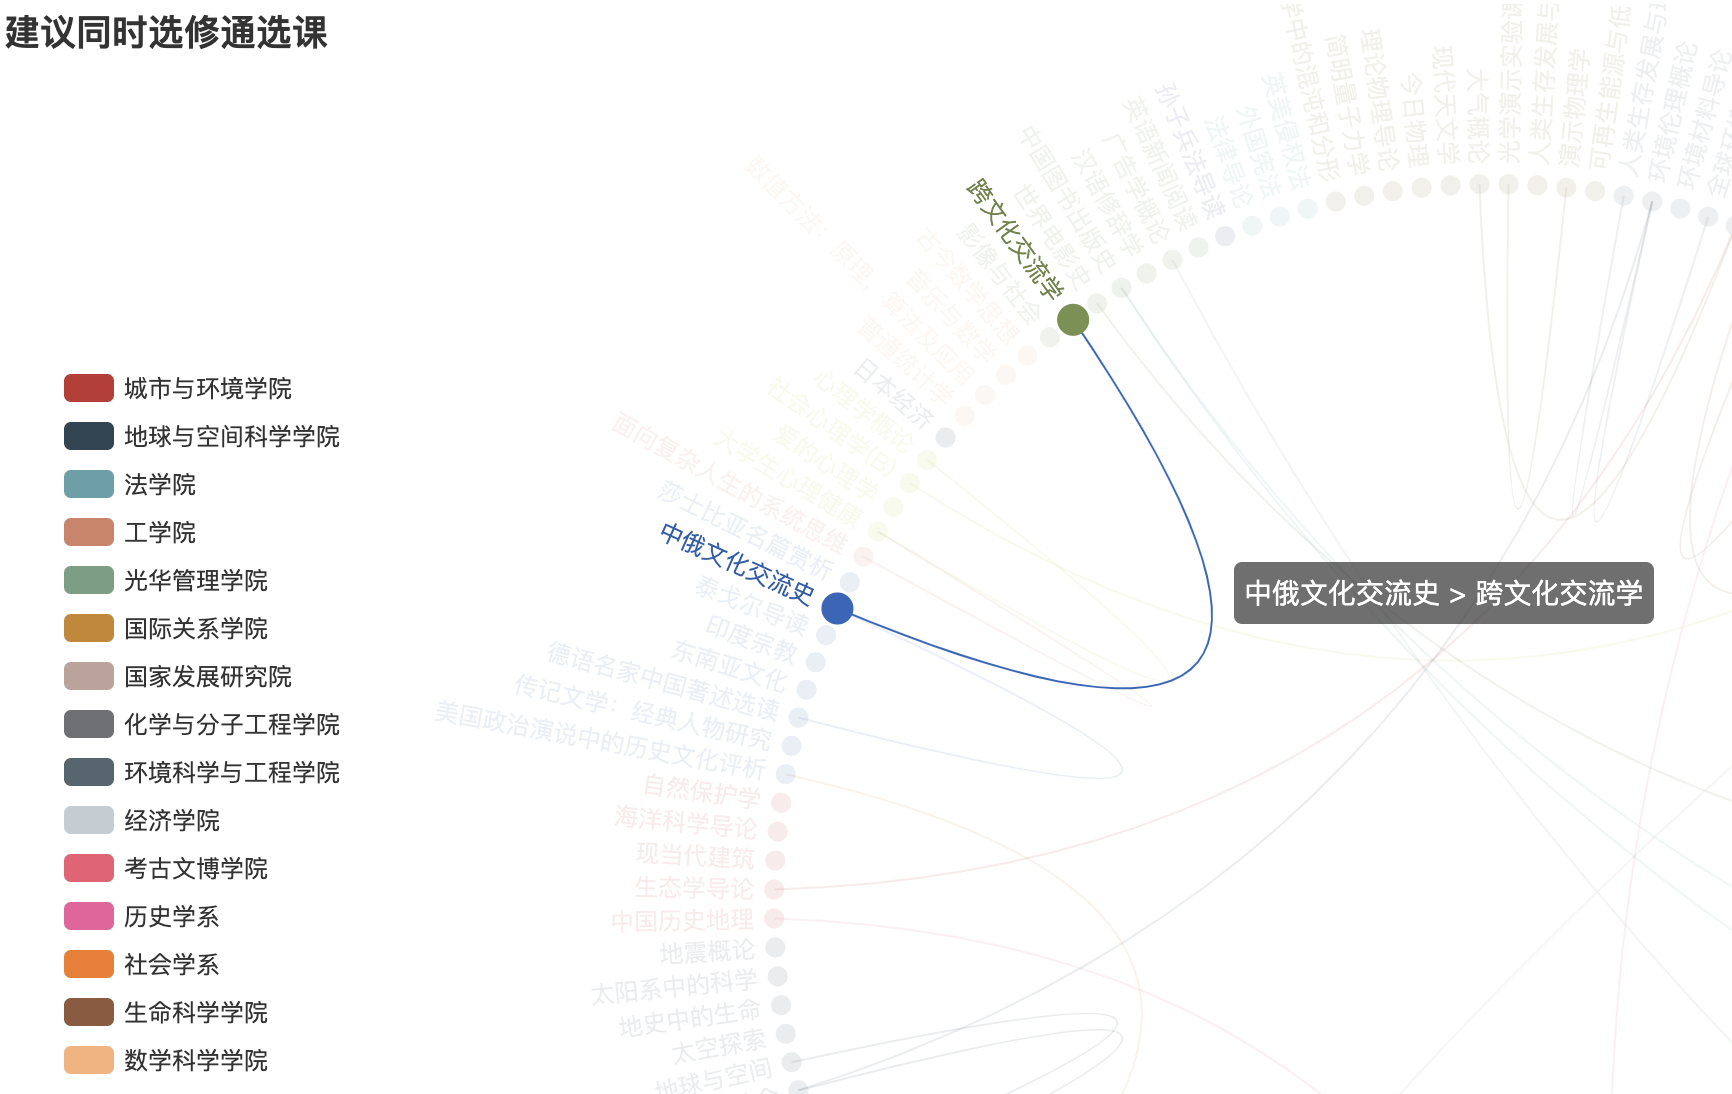


上图使用pyechart生成，请点击‘建议同时选修通选课.html’文件，该文件可交互展示。\
如果同学们已经选修了1门及以上通选课，可以考虑参照上图选修其他与已选修课程相关度较高的课程。\
一方面，可以根据既有兴趣拓展开来，更全面地了解该领域；另外一方面，有了先前的铺垫会更方便新知识理解、减轻同学们之后的课业负担的同时好拿高分。